# The Music of the Sphere: 100 Posterior Sample Planck CMB Temperature Maps, and the Statistics of their Spherical Harmonic Decomposition

*Phil Marshall, Roger Blandford, Ingunn Kathrine Wehus and Hans Kristian Eriksen, August 2015*

In this notebook we download 100 posterior sample Commander Planck CMB temperature maps, decompose them into spherical harmonics, and look at the statistics of the first few components.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import healpy as hp
import os.path
import glob
import numpy as np
import corner

In [3]:
# This will create the Multiverse beatbox.You. To change the default l and n ranges to visualize/play with/reconstruct
#    for all instances of the data, simulated, and reconstructed Universes that will be created afterwards, 
#    please edit the __init__.py file.
import beatbox
beatbox.You.create_original_Universe()

1


## 1. Unpacking the Samples

Lets download the tarball containing 100 posterior sample ["COMMANDER-Ruler"](http://wiki.cosmos.esa.int/planckpla/index.php/CMB_and_astrophysical_component_maps#COMMANDER-Ruler) low resolution maps. It's 574Mb in size, so might take a few minutes to download.
Once we have the tarball, we unpack it, read each T map into a data instance of a "beatbox" Universe, and then decompose it into spherical harmonics.

In [ ]:
beatbox.You.read_Planck_samples()

Let's take a look at one or two of the samples:

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


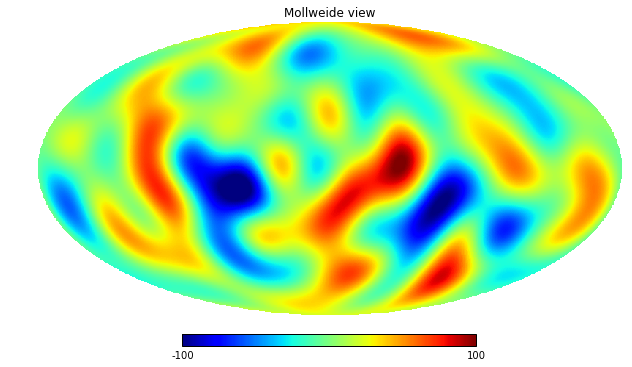

In [19]:
k = 37
beatbox.You.all_data_universes[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

Displaying sky map of the l =  10  and lower spherical harmonics only...
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


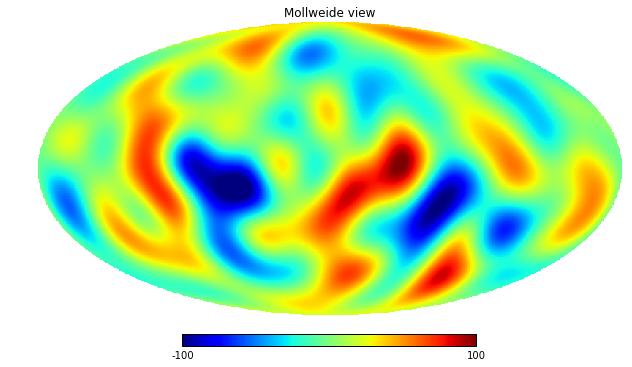

In [20]:
k = 7
beatbox.You.all_data_universes[k].show_lowest_spherical_harmonics_of_CMB_T_map(lmax=10,max=100)

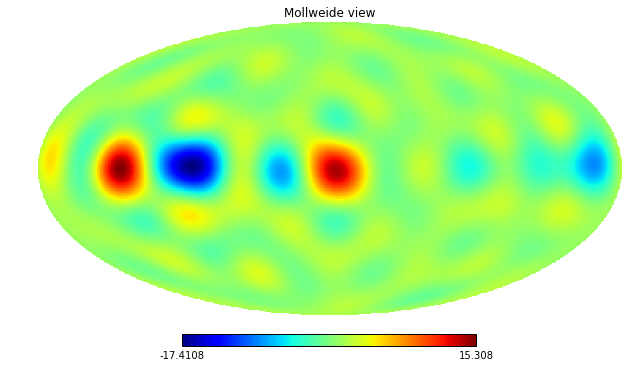

In [22]:
# Let's look at the difference between the maps:
hp.mollview(beatbox.You.all_data_universes[7].truncated_map-beatbox.You.all_data_universes[37].truncated_map,rot=(-90,0,0))

Variations are noticeable but slight - mostly in the galactic plane - Planck took *great* data.

## 2. Statistics of the Spherical Harmonics

For a weighted potential inversion, assuming a multivariate Gaussian distribution of coefficients, we would need the covariance matrix of the `alm`'s. Let's compute that and see how correlated they are.

In [30]:
# Calculate C_yy from the 100 posterior sample Commander Planck CMB temperature maps 
#    or load the C_yy matrix if already calculated

if not os.path.isfile('../data/covCyy_lmax%d.txt' % beatbox.Universe.truncated_lmax):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='lmax%d' % beatbox.Universe.truncated_lmax)
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax%d.txt' % beatbox.Universe.truncated_lmax)
    

Let's now visualize the covariance matrix:

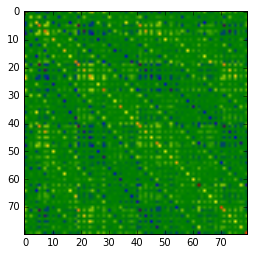

In [31]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(beatbox.You.C_yy)

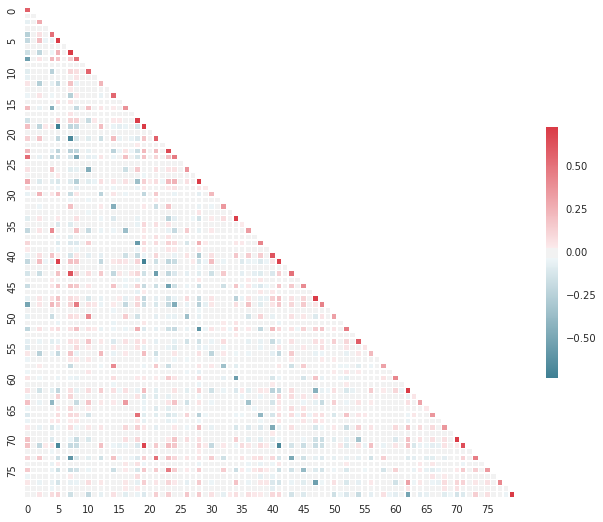

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(beatbox.You.C_yy, dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the covariance matrix as a heatmap with correct aspect ratio
sns.heatmap(beatbox.You.C_yy, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Let's look at the condition number

In [34]:
print "C_yy condition number = ",np.linalg.cond(beatbox.You.C_yy)
import sys
print "Largest meaningful float = ", 1.0/sys.float_info.epsilon

C_yy condition number =  5908301.1345
Largest meaningful float =  4.50359962737e+15


#### Using only up to $l_{max}=8$, it doesn't look like the covariance matrix is ill-conditioned. Let's look at higher values of $l_{max}$. 

#### For $l_{max}=10$:

In [51]:
if not os.path.isfile('../data/covCyy_lmax%d.txt' % 10):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='lmax%d' % 10)
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax%d.txt' % 10)

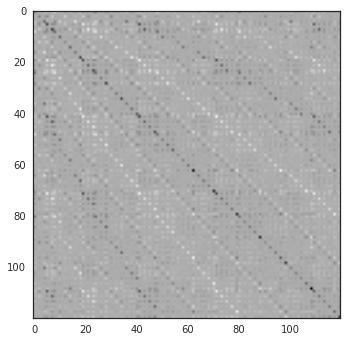

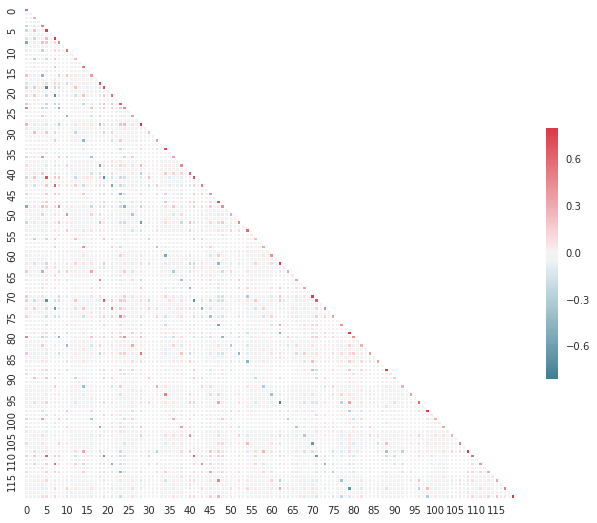

In [39]:
imgplot = plt.imshow(beatbox.You.C_yy)

sns.set(style="white")
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(beatbox.You.C_yy, dtype=np.bool)
mask[np.triu_indices_from(mask,k=1)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the covariance matrix as a heatmap with correct aspect ratio
sns.heatmap(beatbox.You.C_yy, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [38]:
print "C_yy condition number = ",np.linalg.cond(beatbox.You.C_yy)
import sys
print "Largest meaningful float = ", 1.0/sys.float_info.epsilon

C_yy condition number =  8.89592488067e+17
Largest meaningful float =  4.50359962737e+15


Looks like for $l_{max}=10$ the covariance matrix is already ill-conditioned. Let's look at how many e-values are singular.

In [52]:
U, s, V_star = np.linalg.svd(beatbox.You.C_yy)
print len(s)
print len(s[np.where(s<1e-10)])

120
21


So our covariance matrix has 99 positive e-values. This makes a lot of sense since we calculated he covariance matrix from exactly 100 sample maps. Let's test if this remains true as we increase $l_{max}$.

####  How bad is it for $l_{max}=30$?

In [4]:
if not os.path.isfile('../data/covCyy_lmax%d.txt' % 30):
    beatbox.You.read_Planck_samples()
    beatbox.You.calculate_covariance_matrix(filename='lmax%d' % 30)
else:
    beatbox.You.load_covariance_matrix(filename='covCyy_lmax%d.txt' % 30)

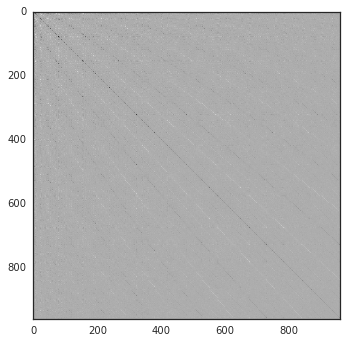

In [43]:
imgplot = plt.imshow(beatbox.You.C_yy)


In [41]:
print "C_yy condition number = ",np.linalg.cond(beatbox.You.C_yy)
import sys
print "Largest meaningful float = ", 1.0/sys.float_info.epsilon

C_yy condition number =  4.81283416066e+20
Largest meaningful float =  4.50359962737e+15


That's also ill conditioned, as we expected... Let's look at the number of effectively zero e-values:

In [47]:
U, s, V_star = np.linalg.svd(beatbox.You.C_yy)

In [50]:
print len(s)
print len(s[np.where(s<1e-10)])

960
861


That means that from the 960 e-values, only 99 are positive, exactly as before with $l_{max}=10$. This is consistent with the fact that having only 100 samples to construct the covariance, we should only expect to be able to constraint 100 (well, here 99) degrees of freedom.



Remarkably SVD is capable of finding a reasonable inverse, from which it's possible to get a reasonable reconstruction. For example, if we generate a mock Universe with $l_{max}=30$ and $n_{max}=6$, here is the reconstruction:

In [5]:
beatbox.You.calculate_sdv_Cyy_inverse()

In [6]:
beatbox.You.initiate_simulated_universe()

Generated  924  potential Fourier coefficients
 with phases uniformly distributed between 0 and  3.14159265359
Built potential grid, with dimensions  (41, 41, 41)  and mean value  -0.0 +/- 0.0003245


/Users/LaurencePeanuts/Documents/Travail/Stanford/Music/Music/beatbox/universe.py:546: RuntimeWarning: divide by zero encountered in power
  self.Power_Spectrum = self.PSnorm*1000*np.power((self.k/self.kstar) ,(-3+(self.n_s-1)))


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


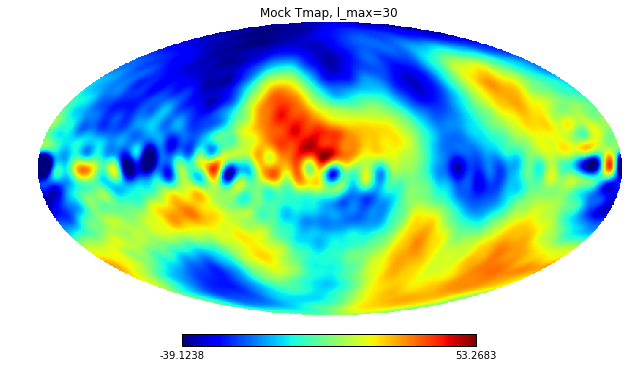

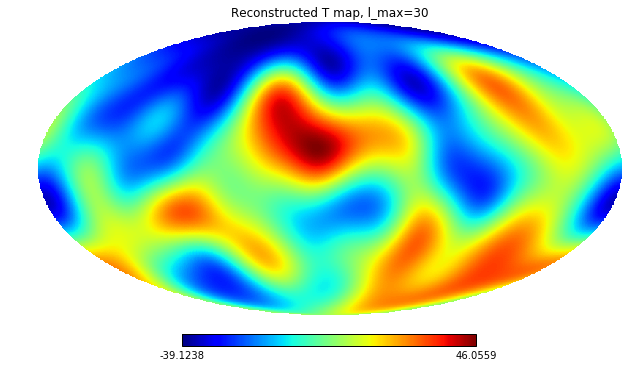

In [10]:
# Generate one realization of noise
noise = beatbox.You.generate_one_realization_of_noise()
# Add the noise to the realization of the sky map
datamap = beatbox.You.all_simulated_universes[-1].ay2ayreal_for_inference(beatbox.You.all_simulated_universes[-1].ay)+noise
datamap = datamap.T
MockUniverse=beatbox.Universe()
MockUniverse.ayreal2ay_for_mapping(datamap)
MockUniverse.ay2alm(MockUniverse.ay)
MockUniverse.Tmap = hp.alm2map(MockUniverse.alm,256)
hp.mollview(MockUniverse.Tmap,  rot=(-90,0,0), min=-39.1238, title="Mock Tmap, l_max=%d" % beatbox.Universe.truncated_lmax)

# Reconstruct the potential
beatbox.You.solve_for_3D_potential(datamap)


# Give those reconstructed f_n's to one realization of the Universe
We = beatbox.Universe()
We.fn = beatbox.You.reconstrunct_fn
#We.fn = beatbox.You.all_simulated_universes[-1].fn * 0.5
We.transform_3D_potential_into_alm(truncated_nmax=We.truncated_nmax, truncated_nmin=We.truncated_nmin,truncated_lmax=We.truncated_lmax, truncated_lmin=We.truncated_lmin,usedefault=1, fn=1)
We.show_CMB_T_map(title = 'Reconstructed T map', from_perspective_of="observer")

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


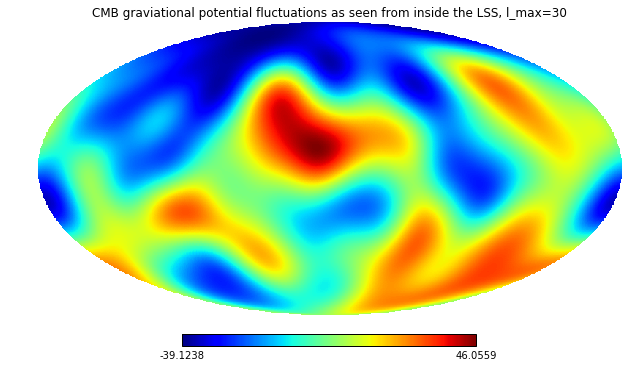

In [15]:
# True value without noise
beatbox.You.all_simulated_universes[-1].show_CMB_T_map(from_perspective_of="observer")

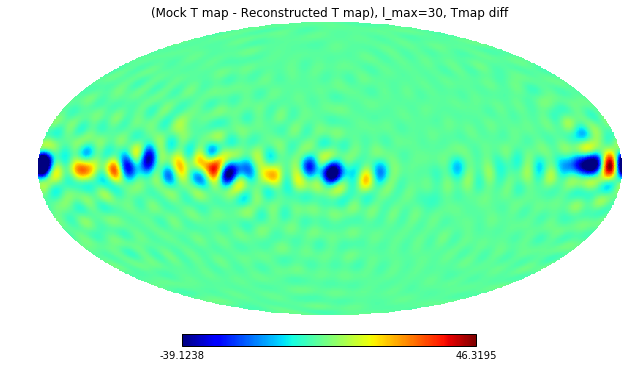

In [18]:
hp.mollview(MockUniverse.Tmap-We.Tmap,  rot=(-90,0,0), min=-39.1238, title="(Mock T map - Reconstructed T map), l_max=%d, Tmap diff" % We.truncated_lmax)

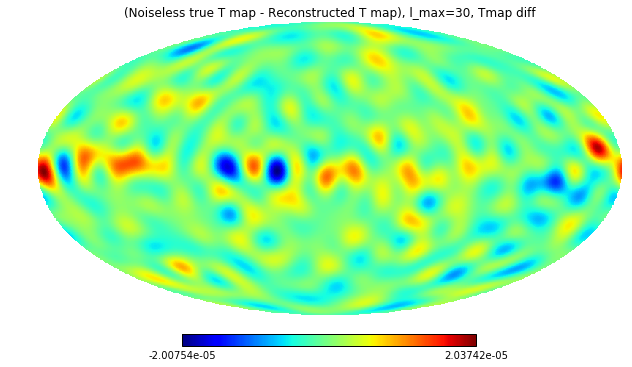

In [17]:
hp.mollview(beatbox.You.all_simulated_universes[-1].Tmap-We.Tmap,  rot=(-90,0,0), title="(Noiseless true T map - Reconstructed T map), l_max=%d, Tmap diff" % 30)

However I'm not convinced it's wise to trust these result too much since as we saw the $a_{lm}$ covariance matrix is really ill-conditioned. The next step would be to look at the covariance of the posterior and see what is the uncertainty on the reconstructed $f_n$'s.